<a href="https://colab.research.google.com/github/Rafe2001/Flower_Recognition/blob/main/DEEP_LEARNING_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Plant Recognition system using PyTorch

1. Pick a dataset
2. Download the dataset
3. Import the dataset using pytorch
4. Explore the dataset
5. Prepare the dataset for training

### Download the Dataset

Using `opendatasets` and download the datasat from https://www.kaggle.com/alxmamaev/flowers-recognition .

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = "https://www.kaggle.com/datasets/alxmamaev/flowers-recognition"

In [ ]:
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [ ]:
data_dic = '/content/flowers-recognition/flowers'

In [ ]:
import os
os.listdir(data_dic)

['tulip', 'sunflower', 'dandelion', 'daisy', 'rose']

In [ ]:
for cls in os.listdir(data_dic):
  print(cls, ':', len(os.listdir(data_dic + '/' + cls)))

tulip : 984
sunflower : 733
dandelion : 1052
daisy : 764
rose : 784


### Import the datasets into PyTorch
Use the ImageFolder class from torchvision

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dic)

In [ ]:
len(dataset)

4317

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F6EFE3C7DF0>, 0)

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

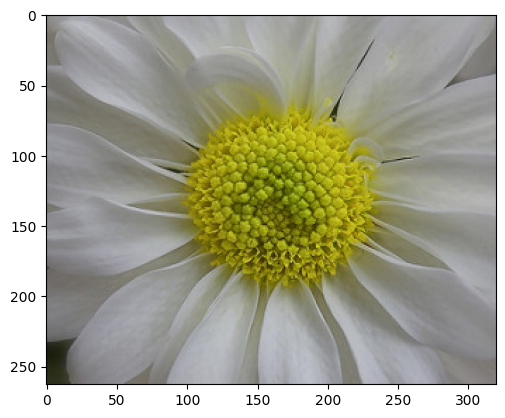

In [ ]:
img, label = dataset[0]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dic, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

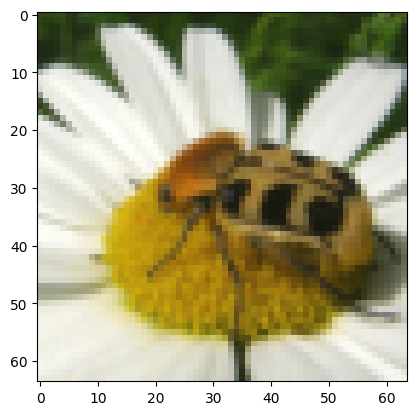

In [ ]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_set = 0.1
val_size = int(val_set*len(dataset))
train_size= len(dataset) - val_size
train_size, val_size

(3886, 431)

In [ ]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [ ]:
train_d1  = DataLoader(train_ds,
                       batch_size,
                       shuffle = True,
                       num_workers=4,
                       pin_memory=True)
valid_d1 = DataLoader(valid_ds,
                     batch_size,
                     num_workers=4,
                     pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_function(d1):
  for images, labels in d1:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

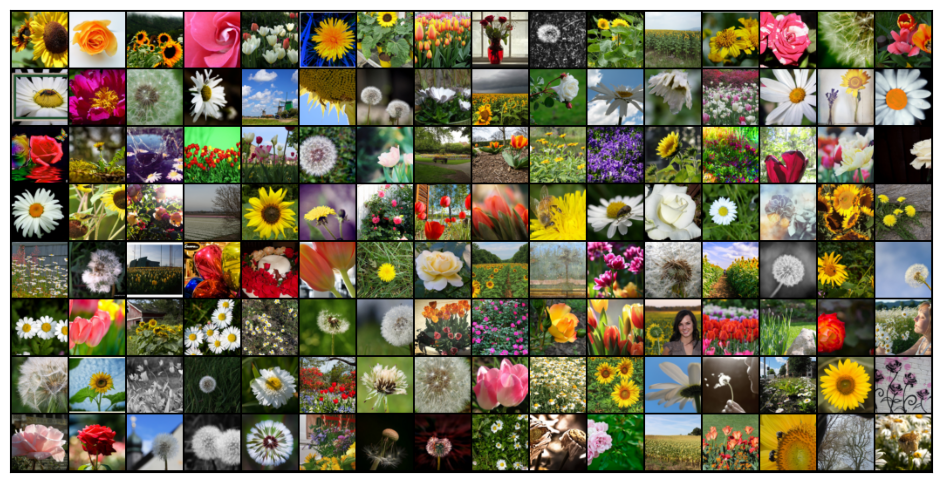

In [ ]:
show_function(train_d1)

##Utility Functions & Classes

In [ ]:
import torch
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):

  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self,d1,device):
    self.d1 = d1
    self.device = device

  def __iter__(self):
    for b in self.d1:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.d1)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_d1 = DeviceDataLoader(train_d1, device)
valid_d1 = DeviceDataLoader(valid_d1, device)

### Model and Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

##Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one of input tensor through the model

In [ ]:
torch.cuda.empty_cache()
for batch in train_d1:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


In [ ]:
history = [evaluate(model, valid_d1)]
history

[{'val_loss': 1.6094800233840942, 'val_acc': 0.18762466311454773}]

In [ ]:
history += fit(5, 0.001, model, train_d1, valid_d1, torch.optim.Adam)

Epoch [0], train_loss: 1.3474, val_loss: 1.5613, val_acc: 0.3527
Epoch [1], train_loss: 0.9882, val_loss: 1.0138, val_acc: 0.6148
Epoch [2], train_loss: 0.8646, val_loss: 0.9064, val_acc: 0.6714
Epoch [3], train_loss: 0.7640, val_loss: 0.9504, val_acc: 0.6555
Epoch [4], train_loss: 0.6880, val_loss: 0.7900, val_acc: 0.7029


In [ ]:
history += fit(5, 0.001, model, train_d1, valid_d1, torch.optim.Adam)

Epoch [0], train_loss: 0.8267, val_loss: 0.8273, val_acc: 0.7185
Epoch [1], train_loss: 0.6907, val_loss: 0.6776, val_acc: 0.7593
Epoch [2], train_loss: 0.5782, val_loss: 0.7211, val_acc: 0.7286
Epoch [3], train_loss: 0.4978, val_loss: 0.6787, val_acc: 0.7618
Epoch [4], train_loss: 0.5503, val_loss: 0.8820, val_acc: 0.7306


In [ ]:
history += fit(5, 0.0001, model, train_d1, valid_d1, torch.optim.Adam)

Epoch [0], train_loss: 0.3834, val_loss: 0.5253, val_acc: 0.8092
Epoch [1], train_loss: 0.3358, val_loss: 0.5261, val_acc: 0.7916
Epoch [2], train_loss: 0.3275, val_loss: 0.5049, val_acc: 0.8246
Epoch [3], train_loss: 0.3141, val_loss: 0.4837, val_acc: 0.8165
Epoch [4], train_loss: 0.3045, val_loss: 0.5444, val_acc: 0.7872


In [ ]:
history += fit(5, 0.0001, model, train_d1, valid_d1)

Epoch [0], train_loss: 0.2750, val_loss: 0.5079, val_acc: 0.8149
Epoch [1], train_loss: 0.2702, val_loss: 0.5050, val_acc: 0.8042
Epoch [2], train_loss: 0.2738, val_loss: 0.5247, val_acc: 0.8056
Epoch [3], train_loss: 0.2874, val_loss: 0.5260, val_acc: 0.8115
Epoch [4], train_loss: 0.2834, val_loss: 0.5240, val_acc: 0.8129


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

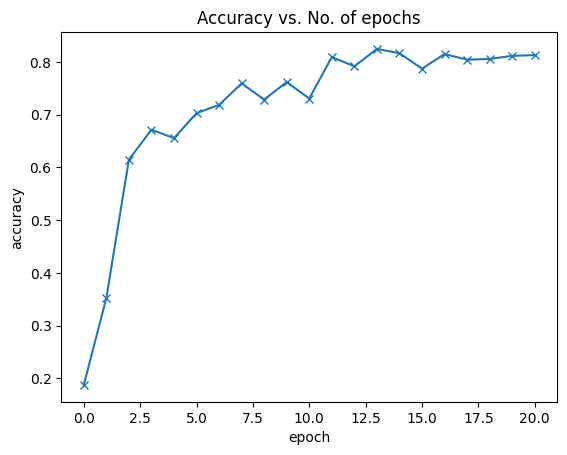

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_loss = [x.get('train_loss') for x in history]
  val_loss = [x['val_loss'] for x in history]
  plt.plot(train_loss, '-bx')
  plt.plot(val_loss, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])
  plt.title('Loss vs No. of epochs')
  plt.show()

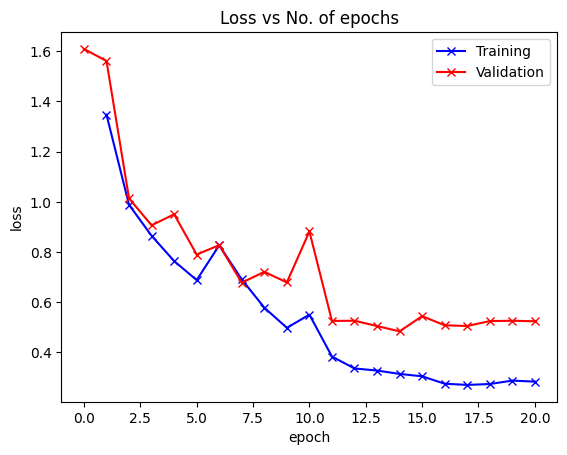

In [ ]:
plot_losses(history)